In [1]:
from PIL import Image
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # add relative path

from module.sttr import STTR
from dataset.preprocess import normalization, compute_left_occ_region
from utilities.misc import NestedTensor

In [2]:
# Default parameters
args = type('', (), {})() # create empty args
args.channel_dim = 128
args.position_encoding='sine1d_rel'
args.num_attn_layers=6
args.nheads=8
args.regression_head='ot'
args.context_adjustment_layer='cal'
args.cal_num_blocks=8
args.cal_feat_dim=16
args.cal_expansion_ratio=4

In [3]:
model = STTR(args).cuda().eval()

In [4]:
# Load the pretrained model
model_file_name = "../kitti_finetuned_model.pth.tar"
checkpoint = torch.load(model_file_name)
pretrained_dict = checkpoint['state_dict']
model.load_state_dict(pretrained_dict, strict=False) # prevent BN parameters from breaking the model loading
print("Pre-trained model successfully loaded.")

Pre-trained model successfully loaded.


In [5]:
import torch
from torchsummary import summary
# Assume model is your model
#summary(model, input_size=(1, 64, 64))


(375, 1242, 3)
(375, 1242, 3)


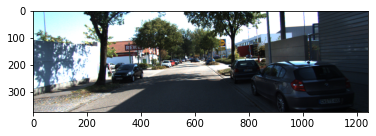

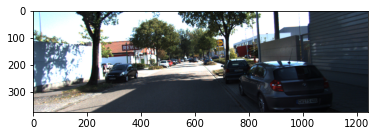

In [6]:
left = np.array(Image.open('../Data/left1.png'))
right = np.array(Image.open('../Data/right1.png'))
# Visualize image
plt.figure(1)
plt.imshow(left)
plt.figure(2)
plt.imshow(right)

print(left.shape)
print(right.shape)

# donwsample attention by stride of 3
h, w, _ = left.shape
bs = 1

downsample = 3
col_offset = int(downsample / 2)
row_offset = int(downsample / 2)
sampled_cols = torch.arange(col_offset, w, downsample)[None,].expand(bs, -1).cuda()
sampled_rows = torch.arange(row_offset, h, downsample)[None,].expand(bs, -1).cuda()

input_data = {'left': left, 'right':right}
input_data = normalization(**input_data)

# build NestedTensor
input_data = NestedTensor(input_data['left'].cuda()[None,],input_data['right'].cuda()[None,], sampled_cols=sampled_cols, sampled_rows=sampled_rows)

In [7]:
output = model(input_data)

../module/pos_encoder.py:56: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


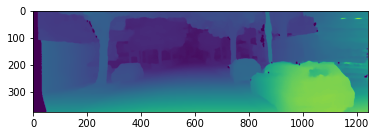

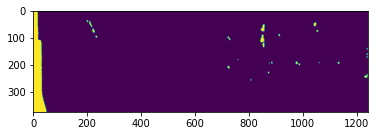

In [8]:
disp_pred = output['disp_pred'].data.cpu().numpy()[0]
occ_pred = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_pred[occ_pred] = 0.0


plt.figure(3)
plt.imshow(disp_pred)
plt.figure(4)
plt.imshow(occ_pred)

In [9]:
disp_pred[300][1000]


80.53171

In [10]:
np.mean(disp_pred)

33.286674

In [11]:
disp_pred.shape

(375, 1242)

In [12]:
def parse_projection_matrix(file_path):
    # Define prefixes for the cameras of interest
    cam_prefixes = ["P_rect_02", "P_rect_03"]

    # Create a dictionary to hold the projection matrices
    projection_matrices = {}

    # Open the file and read its content
    with open(file_path, 'r') as f:
        lines = f.readlines()

        # Go through each line in the file
        for line in lines:
            # Split the line to extract key and values, limited to producing only two parts
            parts = line.split(':', 1)
            if len(parts) < 2:
                continue
            key, values = parts
            key = key.strip()

            # Check if the current line is one of the camera matrices we are interested in
            if key in cam_prefixes:
                # Convert the space separated string values to a list of floats
                values_list = list(map(float, values.strip().split()))

                # Convert the list of floats to a 3x4 numpy matrix
                matrix = np.array(values_list).reshape(3, 4)

                # Add the matrix to the dictionary with the camera prefix as the key
                projection_matrices[key] = matrix
    
    left_prj_mat = projection_matrices['P_rect_02']
    right_prj_mat = projection_matrices['P_rect_03']

    return (left_prj_mat, right_prj_mat)

In [13]:
left_prj, right_prj = parse_projection_matrix('../Data/calib_cam_to_cam.txt')
print(left_prj)
print(right_prj)

[[7.215377e+02 0.000000e+00 6.095593e+02 4.485728e+01]
 [0.000000e+00 7.215377e+02 1.728540e+02 2.163791e-01]
 [0.000000e+00 0.000000e+00 1.000000e+00 2.745884e-03]]
[[ 7.215377e+02  0.000000e+00  6.095593e+02 -3.395242e+02]
 [ 0.000000e+00  7.215377e+02  1.728540e+02  2.199936e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  2.729905e-03]]


In [14]:
def convert_disp_to_depth_map(disp_map, P_left, P_right, cutoff_thresh = 0.1):
    # 从Projection Matrix中提取f
    f_left = P_left[0, 0]
    f_right = P_right[0, 0]


    # 如果相机已经被矫正并平行于X轴，则基线b可以从投影矩阵中提取
    b = P_right[0, 2] / f_right
    #print(b)
    #print(f_left)
    
    depth_map = np.zeros_like(disp_map)
    for (i, j), disp in np.ndenumerate(disp_map):
        if abs(disp) < cutoff_thresh:
            depth_map[i][j] = -1
        else:
            depth_map[i][j] = (f_left * b) / disp
    return depth_map
    
    

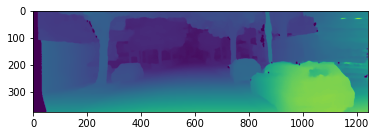

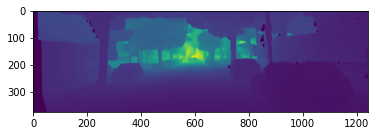

In [15]:
disp_map = disp_pred
min_disp = np.min(disp_map)
max_disp = np.max(disp_map)
normalized_disp_map = (disp_map - min_disp) / (max_disp - min_disp)


depth_map = convert_disp_to_depth_map(disp_pred, left_prj, right_prj, 0.1)
min_depth = np.min(depth_map)
max_depth = np.max(depth_map)
normalized_depth_map = (depth_map - min_depth) / (max_depth - min_depth)

plt.figure(5)
plt.imshow(normalized_disp_map)
plt.figure(6)
plt.imshow(normalized_depth_map)

In [23]:
import cv2

def disparity_to_3D_points(left_prj, right_prj, disparity):
    """
    Convert disparity map to 3D points using the given projection matrices.

    Parameters:
    - left_prj: 3x4 numpy array representing the left rectified projection matrix.
    - right_prj: 3x4 numpy array representing the right rectified projection matrix.
    - disparity: 2D numpy array representing the disparity map.

    Returns:
    - 3D numpy array with shape (H, W, 3) representing the 3D points.
    """
    # Compute Q matrix from projection matrices
    f = left_prj[0, 0]  # Focal length, assuming it's the same for both cameras after rectification
    T = right_prj[0, 3] / f  # Baseline

    Q = np.array([
        [1, 0, 0, -0.5 * disparity.shape[1]],
        [0, -1, 0, 0.5 * disparity.shape[0]],
        [0, 0, 0, -f],
        [0, 0, -1 / T, 0]
    ])

    # Reproject image to 3D
    points_3D = cv2.reprojectImageTo3D(disparity, Q)
    return points_3D


In [26]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [30]:
def visualize_3D_points_with_open3d(points_3D):
    """
    Visualize the given 3D points using Open3D with a default color.

    Parameters:
    - points_3D: 3D numpy array with shape (H, W, 3) representing the 3D points.

    Returns:
    - None.
    """
    # Create a PointCloud object from Open3D
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3D.reshape(-1, 3))
    
    # Visualize
    o3d.visualization.draw_geometries([pcd])


points_3D = disparity_to_3D_points(left_prj, right_prj, disp_map)

# Mask out points where disparity is 0 (or less) as they're likely invalid
mask = disp_map > 0
valid_points_3D = points_3D[mask]

visualize_3D_points_with_open3d(valid_points_3D)

[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.
